# $\color{purple}{\text{Classification of Names by Gender}}$

**By Alexander Ng & Philip Tanofsky**

*April 3, 2022*



## $\color{blue}{\text{Overview}}$

We consider the classification of over 6000 given names by gender through the use of machine learning within the framework of linguistic theory.  The goal of this study is to predict the gender of name $X$ given nothing more than a training set of other names.   To construct useful predictors, we use both an orthographic and a phonetic approach to analyze the names corpus.  These predictors extract additional information necessary for accurate gender classification.  

We review the background literature on the plausibility of a phonological approach to gender classification, then describe our data set including the derived predictors and an exploratory analysis.  Lastly, the model results are presented.

## $\color{blue}{\text{Theoretical Background}}$

There is a research literature on the prediction of gender of first names based on phonological consideration.   [Slepian and Galinsky (2016)](http://www.columbia.edu/~ms4992/Pubs/2016_Slepian-Galinsky_JPSP.pdf) show that voiced initial phonemes in first names are more associated with male names while unvoiced initial phonemes are associated with female names.   [Sullivan and Kang (2019)](http://www.assta.org/proceedings/ICPhS2019/papers/ICPhS_2173.pdf) conducted field experiments with nonsense names that follow known phonological patterns to confirm a gender preference in names.   [Whissell (2013)](https://doi.org/10.1179/nam.2001.49.2.97) note that predictability in gender of names is supported by the linguistic theory of *sound symbolism*.

**Sound symbolism** argues that the sound of a word is associated with the word's referent.  "Sound  patterns in words are both non-random and informative." [Whissell (2013)](https://doi.org/10.1179/nam.2001.49.2.97)   These studies challenge the prevailing theory that the relationship between a word and its meaning are arbitrary.  This arbitrariness is a fundamental aspect of language. 

The key patterns observed in names and their gender associations are:

*  **Diversity of names**  Female names are more diverse than male ones.

*  **Number of Syllables**  Female names have more syllables than male ones.

*  **Final Syllable** Female names are more likely to end in a *schwa* or open vowel.

*  **Stress Placement**  Female names have stress on syllable after the first one.

*  **Fewer Consonants**  Male names have fewer consonants.

*  **Voiced Consonant**  Male names have more initial voiced consonants.

These findings enable us to construct additional predictors to guide the classification models.  A big question is whether these effects work together in concert to increase prediction accuracy.


## $\color{blue}{\text{Data and Methods}}$

To obtain these phonemes of each name, the syllables and stress placement, we require an automated way to obtain and codify the pronunciation of the entire name corpus.   We used the CMU pronunciation library on the backend to compute the pronunciation of each name.   The front-end software package was `pronouncing`.   The CMU and `pronouncing` library produce a string representation of the phonemes of the names.   It can also gives the number of syllables, the stress placement.   The phonemes are encoded in a special convention called `Arpabet` which was developed by the DARPA agency for automated text translation.   For example, the `schwa` is encoded as a two letter string `AH`.   The article [Arpabet](https://en.wikipedia.org/wiki/ARPABET) gives more details of the encoding.  It represents a subset of IPA (the International Phonetic Alphabet) and is geared to capture American English.



The biggest challenge was that only 66% of the nltk names corpus is covered by the `pronouncing` library.  No attempt is made by the CMU dictionary to guess the pronunciation of many relatively simple words.

Thus, we also use the `Double Metaphone` sound encoding algorithm (based on its ancestor `Soundex`) to construct an alphanumeric representation of each name in a simple string format.  This `dmeta` encoding gives us an additional way to obtain pronunciation data.  Because vowels are stripped off, we do not expect Double Metaphone to be useful in all cases.   For example, ROBERT and ROBERTA map to the same `dmeta` result.

In total, we construct the following predictors:
    
*  first letter
*  second letter
*  first two letters
*  last letter
*  last 2 letters
*  word length
*  number of consonants (non-phonemically computed)
*  number of vowels (aeiou only - not phonemically derived)
*  Double metaphone encoding of the name
*  phoneme 1 - 12.  Each name can have up to 12 phonemes.
*  phoneme string (The raw string from CMU).
*  first phoneme
*  number of phonemes
*  number of syllables
*  the syllable at which the primary stress is pronounced
*  the last phoneme of the name


To ensure reproducibility of the study, we seed the random number generator prior to splitting the test train split.

To deal with the data discrepancy between the complete set of names and the partial set with all phonemic data, we run TWO models.

One analysis uses the basic set of features that don't require the CMU pronouncing library.   We call that the basic features data set.

Another analysis uses the entire set of column (including the phonological features) but is limited to 66% of the original names corpus.   We call this the advanced feature set.




## $\color{blue}{\text{Exploratory Data Analysis}}$

First, we explore a few aspects of the names dataset to better understand the nature of the provided names.

In [1]:
# Import required modules
import pandas as pd
import nltk
from nltk.corpus import names
from nltk.metrics import ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
import pronouncing
import phonetics
from collections import Counter
import random

Retrieve the female and male names and label them based on the file name. Shuffle the names based on random seed to generate an even mix of female and male names for the train, devtest, and test subsets. Again, the random seed is used to ensure reproducibility.

In [2]:
# Make sure to remove any whitespace at the end of the names using rstrip(). Found one example of "Gale ".
labeled_names = ([(name.rstrip(), 'male') for name in names.words('male.txt')] +
[(name.rstrip(), 'female') for name in names.words('female.txt')])

# Set seed to ensure the simulation can be reproduced.
random.seed(a = 102)  
random.shuffle(labeled_names)

Output dataframe head to confirm data load worked.

In [3]:
df_lab_names = pd.DataFrame(labeled_names, columns=['name','gender'])
df_lab_names['name'] = df_lab_names['name'].str.lower()
df_lab_names['name'] = df_lab_names['name'].str.rstrip()
df_lab_names.head()

,name,gender
0,bridie,female
1,edeline,female
2,molli,female
3,ingeberg,female
4,willmott,male


Identify count of female and male names included.

In [4]:
Counter(df_lab_names.gender)

Counter({'female': 5001, 'male': 2943})

The gender totals indicate a higher number of provided female names compared to male names.

### $\color{blue}{\text{Unique Names}}$
Identify number of unique female names.

In [5]:
# Get the female rows
df_names_female = df_lab_names.loc[df_lab_names['gender'] == 'female']
print('Count of unique female names: {:-4}'.format(len(df_names_female.name.unique())))

Count of unique female names: 4997


Identify number of unique male names.

In [6]:
# Get the male rows
df_names_male = df_lab_names.loc[df_lab_names['gender'] == 'male']
len(df_names_male.name.unique())
print('Count of unique male names: {:-4}'.format(len(df_names_male.name.unique())))

Count of unique male names: 2943


Identify number of total unique names.

In [7]:
print('Count of unique names: {:-4}'.format(len(df_lab_names.name.unique())))

Count of unique names: 7575


Identify count of names common in female and male lists.

In [8]:
print('Count of names common in female and male lists: {:-4}'.format((7575 - 4997 - 2943) * -1))

Count of names common in female and male lists:  365


### $\color{blue}{\text{Name Lengths}}$

Identify the shortest and longest name lengths.

Shortest names: 2 characters. Following shows a sample of 2-character names.

In [9]:
df_names_short = df_lab_names.loc[df_lab_names['name'].str.len() < 3]
df_names_short.head()

,name,gender
1108,ev,male
1149,er,male
1264,ty,male
1424,vi,female
1760,ed,male


Longest names: 15 characters. Following shows the two examples of 15-character names.

In [10]:
df_names_long = df_lab_names.loc[df_lab_names['name'].str.len() > 14]
df_names_long.head()

,name,gender
1090,jean-christophe,male
5121,helen-elizabeth,female


### $\color{blue}{\text{Letter Distribution}}$

We plot the first, second, and final letter distributions by gender to identify any patterns.

Slice the first character, second character, and final character from each name.

In [11]:
df_lab_names['SW1L'] = df_lab_names['name'].astype(str).str[0]
df_lab_names['SW2L'] = df_lab_names['name'].astype(str).str[1:2]
df_lab_names['EW1L'] = df_lab_names['name'].astype(str).str[-1]
df_lab_names.head()

,name,gender,SW1L,SW2L,EW1L
0,bridie,female,b,r,e
1,edeline,female,e,d,e
2,molli,female,m,o,i
3,ingeberg,female,i,n,g
4,willmott,male,w,i,t


Plot the first letter counts by gender.

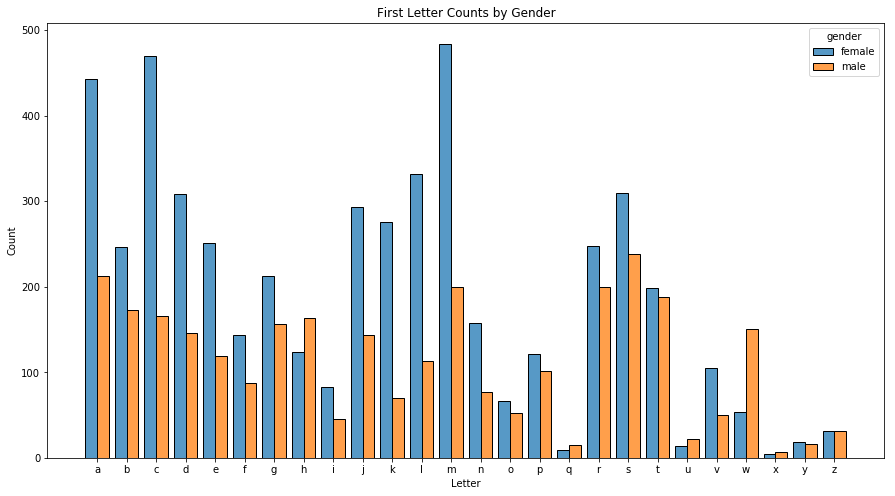

In [12]:
palette = {
    'female': 'tab:blue',
    'male': 'tab:orange'
}

plt.figure(figsize=(15,8))
sns.histplot(data=df_lab_names.sort_values(by="SW1L"),
             x="SW1L", 
             hue="gender", 
             multiple="dodge", 
             palette=palette,
             shrink=.8
            ).set(title='First Letter Counts by Gender', 
                   xlabel='Letter', 
                   ylabel='Count');

Even accounting for the higher volume of female names, we see names starting with 'a', 'c', 'l', and 'm' are more likely to be female names. We also notice that names starting with 'w' are more likely to be male.

Next, plot the second letter counts by gender.

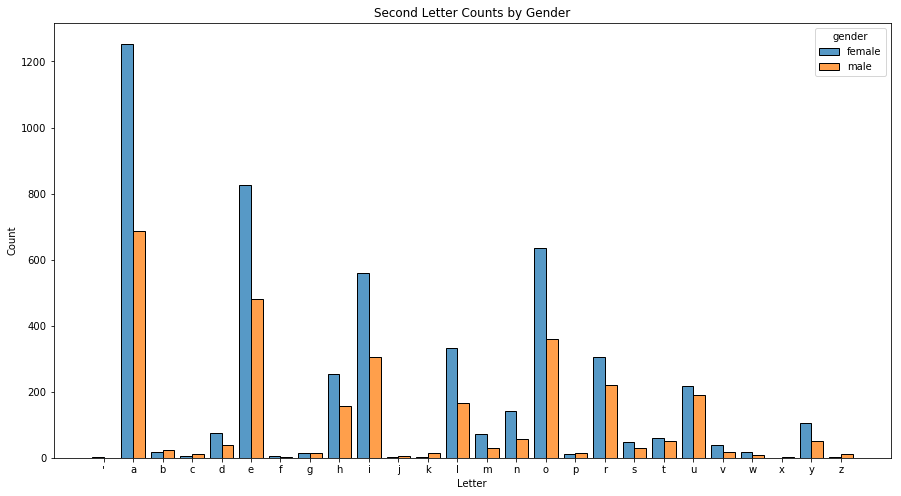

In [13]:
plt.figure(figsize=(15,8))
sns.histplot(data=df_lab_names.sort_values(by="SW2L"),
             x="SW2L", 
             hue="gender", 
             multiple="dodge", 
             palette=palette,
             shrink=.8
            ).set(title='Second Letter Counts by Gender', 
                   xlabel='Letter', 
                   ylabel='Count');

Key takeway from above plot is the likelihood of a vowel being the second character - 'a', 'e', 'i', 'o', and 'u' - which is expected given the general form of names using the English language.

Plot the final letter counts.

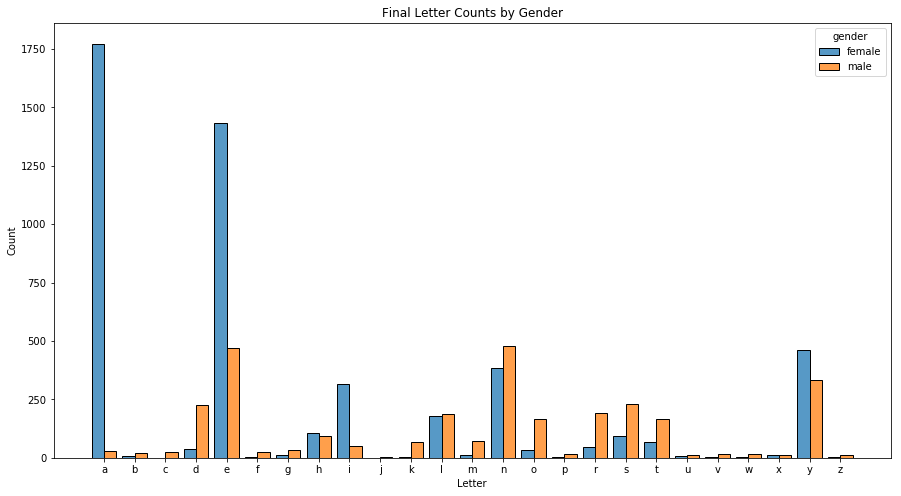

In [14]:
plt.figure(figsize=(15,8))
sns.histplot(data=df_lab_names.sort_values(by="EW1L"),
             x="EW1L", 
             hue="gender", 
             multiple="dodge", 
             palette=palette,
             shrink=.8
            ).set(title='Final Letter Counts by Gender', 
                   xlabel='Letter', 
                   ylabel='Count');

The above plot clearly shows names ending in 'a' or 'e' are likely to be female.

The above plots indicate the likelihood of first and final letters being a reasonable predictor of gender.

## $\color{blue}{\text{Feature Extraction}}$
To prepare the featureset dictionary objects for the nltk classifiers, we created several functions to extract the basic and advanced features based on the name as the sole input.

In [15]:
#  Let's make sure the dictionary keys are globally unique by imposing
#  a namespace qualifier.
#  Use a prefix by feature-type.   
#  Each extractor function computes only 1 feature type.
#  So features in one extractor function 
# -------------------------------------------------------------------------

#   generates the dictionary key name:  
#     var_type = 1  =>  Alphabetical
#     var_type = 2  =>  Integer
#     var_type = 3  =>  Boolean
# -----------------------------------------------
def make_key_name(prefix, var_type , key ):
    if var_type == 1:        
        keyname = prefix + "_" + "A" + "_" + key
    elif var_type == 2:
        keyname = prefix + "_" + "N" + "_" + key
    else:
        keyname = prefix + "_" + "B" + "_" + key
    return keyname


def extract_response(gender):
    pre = "R"
    features = {}
    features[make_key_name(pre, 1, "gender")] = gender
    return features


def count_consonants(string):
   num_consonants = 0
   # to count the consonants
   for char in string:
      if char not in "aeiou":
         num_consonants += 1
   return num_consonants


def count_vowels(string):
   num_vowels = 0
   # to count the voweles
   for char in string:
      if char in "aeiou":
         num_vowels += 1
   return num_vowels


#     Function to extract basic features and create dictionary object
def extract_basic_features(name, one_letter=False, two_letters=True):
    pre = "B"
    features = {}
    
    #features[make_key_name(pre, 1, "name")] = name
    if one_letter:
        features[make_key_name(pre, 1, "firstletter") ] = name[0].lower()
        features[make_key_name(pre, 1, "secondletter")] = name[1].lower()
        features[make_key_name(pre, 1, "lastletter")] = name[-1].lower()
    if two_letters:
        features[make_key_name(pre, 1, "first2letter")] = name[0:2].lower()
        features[make_key_name(pre, 1, "last2letter")] = name[-2:].lower()
    features[make_key_name(pre, 2, "length")] = len(name)
    
    # Count the consonants and vowels
    features[make_key_name(pre, 2, "numconsonants")] = count_consonants(name.lower())
    features[make_key_name(pre, 2, "numvowels")] = count_vowels(name.lower())
    
    dmeta  = phonetics.dmetaphone(name)  # Double Metaphone is usually defined for all names.

    features[make_key_name(pre, 1, "dmetacode")] = dmeta[0] if len(dmeta) > 0 else ""
    features[make_key_name(pre, 2, "dmetalen")]  = len(dmeta[0]) if len(dmeta) > 0 else 0    

    return features

In [16]:
#     Function to extract advanced (phonetic) features and create dictionary object
def extract_phonetic_features(name):
    pre = "P"
    features = {}
    
    # Initial the phoneme split algorithm: 0
    for j in range(0, 12):
        features[make_key_name(pre, 1, "phx_" + str(j).zfill(2) )] = ""

    last_phoneme = ""
    stress_pos =  0  # If value is undefined
    plist = pronouncing.phones_for_word(name)
    num_syllables = 0
    
    # Strip out the accent.
    if len(plist) > 0:
        num_syllables = pronouncing.syllable_count(plist[0])
        stress_string = pronouncing.stresses( plist[0])
        stress_pos = stress_string.find('1') + 1 # Finds the primary stress in the syllable.
        list_phonemes_stressed = str.split(plist[0])
        
        for j in range(0, len(list_phonemes_stressed)):    
            s = list_phonemes_stressed[j]
            s_no_ints = ''.join(x for x in s if not x.isdigit() )
            features[make_key_name(pre, 1, "phx_" + str(j).zfill(2) ) ] = s_no_ints
            
            if j == len(list_phonemes_stressed) - 1 :
                last_phoneme = s_no_ints
    else:
        num_syllables = 0
        
    features[make_key_name(pre, 1, "phcode")] = plist[0] if len(plist) > 0 else ""
    features[make_key_name(pre, 1, "phfirst")] = str.split(plist[0])[0] if len(plist) > 0 else ""
    features[make_key_name(pre, 2, "phlen")] = len( str.split(plist[0]))  if len(plist) > 0 else 0
    features[make_key_name(pre, 2, "phsyllables")] = num_syllables
    features[make_key_name(pre, 3, "phfound")] = True if len(plist) > 0 else False
    features[make_key_name(pre, 2, "phx_stress")] = stress_pos
    features[make_key_name(pre, 1, "phx_last")] = last_phoneme
    return features

In [17]:
#  Helper function to extract basic and phonetic features. 
#  Note: This function can be called to include or exclude the basic features
#  when extracting the advanced features.
def extract_advanced_features(name, include_basic=True):
    features = {}
    if include_basic:
        features ={  **extract_basic_features(name) , **extract_phonetic_features( name ) }
    else:
        features ={ **extract_phonetic_features( name ) }
    return features

Following code loops through the initial list of labeled names to generate the basic and advanced featuresets for input into the nltk classifiers.

In [18]:
i = 0
total_isin = 0
total_notin = 0
total_female_isin = 0
total_female_notin = 0
total_male_isin = 0
total_male_notin = 0

# Construct the dataframe of outputs row-by-row
df_row_sets = []

# Construct the list of dictionaries of only basic feature sets
basic_feature_sets = []

# Construct the list of dictionaries of basic and phonetic features
phonetic_feature_sets = []

phonetic_names = []

for n, g in labeled_names:
    
    i += 1
    
    gfeatures = extract_response(g)
    bfeatures = extract_basic_features(n,True,False)
    afeatures = extract_advanced_features(n)  

    all_features = { **afeatures , **gfeatures } 
    df_row_sets.append( all_features  )
    
    basic_feature_sets.append( ( bfeatures , g ) )
    
    isin = all_features["P_B_phfound"]
    
    # Tabulate statistics on the available pronunciations.
    
    if isin:
        total_isin += 1
        
        # if phonetic data is unavailable can't run the advanced model
        # but if it is save the names and gender
        # and the feature set 
        # ------------------------------------------------
        phonetic_names.append( (n,g ))
        phonetic_feature_sets.append( ( afeatures , g ) )
        
        if g == "female":
            total_female_isin += 1
        else:
            total_male_isin += 1
    else:
        total_notin += 1
        if g == "female":
            total_female_notin += 1
        else:
            total_male_notin += 1
    
    # For debugging
    # --------------------------
    debug = False
    if debug: 
        if i < 10:
            num_syllables = all_features["P_N_phsyllables"]
            pronunciation = all_features["P_A_phcode"]

            print(" Name: ", n , " isin: " , isin , "gender: ", g, 
                      "Phonetic: " , all_features["B_A_dmetacode"] ,
                      "Pronounciation: ", pronunciation, 
                      " syllables: ", num_syllables )

df_features = pd.DataFrame.from_dict( df_row_sets  , orient = 'columns')

Separate the generated featuresets into train, devtest, and test for model evaluation. Then export the training and devtest data jointly.  

In [19]:
df_train_large = df_features[500:]
df_test = df_features[:500]

basic_feature_sets_test = basic_feature_sets[:500]
basic_feature_sets_devtest = basic_feature_sets[500:1000]
basic_feature_sets_train = basic_feature_sets[1000:]
basic_names_test , basic_names_devtest , basic_names_train = labeled_names[:500] , labeled_names[500:1000], labeled_names[1000:]

phonetic_feature_sets_test    = phonetic_feature_sets[:500]
phonetic_feature_sets_devtest = phonetic_feature_sets[500:1000]
phonetic_feature_sets_train   = phonetic_feature_sets[1000:]
phonetic_names_test , phonetic_names_devtest , phone_names_train = phonetic_names[:500] , phonetic_names[500:1000], phonetic_names[1000:]

df_features.to_csv("names_all.csv", index=False)
df_train_large.to_csv("names_train.csv", index = False )
df_test.to_csv( "names_test.csv", index = False )

print("\nGenerated names with features in dataframe format for test-train split\n")


Generated names with features in dataframe format for test-train split



Lastly, we check the test, devtest and training feature sets sizes for basic features and phonetic features.
We can see below that the test and devtest sets are the same size as required: 500.
The phonetic features training set is smaller - roughly 4200 instead of 6900 due to limitations in the CMU pronunciation dictionary.


In [20]:
len(basic_feature_sets_test), len(basic_feature_sets_devtest), len(basic_feature_sets_train)

(500, 500, 6944)

The first featureset of the basic features is displayed below to confirm inclusion of desired features and valid synatx.

In [21]:
basic_feature_sets_train[:1]

[({'B_A_firstletter': 'w',
   'B_A_secondletter': 'i',
   'B_A_lastletter': 'r',
   'B_N_length': 6,
   'B_N_numconsonants': 4,
   'B_N_numvowels': 2,
   'B_A_dmetacode': 'ALPR',
   'B_N_dmetalen': 4},
  'male')]

In [22]:
len(phonetic_feature_sets_test), len(phonetic_feature_sets_devtest), len( phonetic_feature_sets_train )

(500, 500, 4252)

The first featureset of the advanced features is displayed below to confirm inclusion of desired features and valid synatx. By default, the advanced featureset includes both basic and phonetic features.

In [23]:
phonetic_feature_sets_train[:1]

[({'B_A_first2letter': 'co',
   'B_A_last2letter': 'in',
   'B_N_length': 6,
   'B_N_numconsonants': 4,
   'B_N_numvowels': 2,
   'B_A_dmetacode': 'KRPN',
   'B_N_dmetalen': 4,
   'P_A_phx_00': 'K',
   'P_A_phx_01': 'AO',
   'P_A_phx_02': 'R',
   'P_A_phx_03': 'B',
   'P_A_phx_04': 'IH',
   'P_A_phx_05': 'N',
   'P_A_phx_06': '',
   'P_A_phx_07': '',
   'P_A_phx_08': '',
   'P_A_phx_09': '',
   'P_A_phx_10': '',
   'P_A_phx_11': '',
   'P_A_phcode': 'K AO1 R B IH0 N',
   'P_A_phfirst': 'K',
   'P_N_phlen': 6,
   'P_N_phsyllables': 2,
   'P_B_phfound': True,
   'P_N_phx_stress': 1,
   'P_A_phx_last': 'N'},
  'male')]

## $\color{blue}{\text{Model Evaluation}}$

Our model evaluation approach takes the following incremental path:

1. Naive Bayes Classifier with Basic features - one letter features
2. Naive Bayes Classifier with Basic features - one and two letter features
3. Naive Bayes Classifier with Basic features - two letter features
4. Maximum Entropy Classififer with Basic features - two letter features
5. Decision Tree Classifier with Basic features - two letter features
6. Naive Bayes Classifier with Advanced features - phonetic features 
7. Naive Bayes Classifier with Advanced features - basic and phonetic features

For each model, we output the accuracy and most informative features for Naive Bayes classifier.

### $\color{blue}{\text{Basic Features}}$

**1. Naive Bayes Classifier with Basic features - one letter features**

We start with the one-letter features.

In [24]:
classifier_nb_basic = nltk.NaiveBayesClassifier.train( basic_feature_sets_train)
accuracy_model_one = nltk.classify.accuracy( classifier_nb_basic, basic_feature_sets_devtest)
print('Naive Bayes Model Accuracy - One Letter Features Only: {:0.4}'.format(accuracy_model_one))

Naive Bayes Model Accuracy - One Letter Features Only: 0.81


In [25]:
classifier_nb_basic.show_most_informative_features(20)

Most Informative Features
          B_A_lastletter = 'k'              male : female =     41.1 : 1.0
          B_A_lastletter = 'a'            female : male   =     32.1 : 1.0
          B_A_lastletter = 'v'              male : female =     16.4 : 1.0
          B_A_lastletter = 'f'              male : female =     13.9 : 1.0
           B_A_dmetacode = 'MRN'          female : male   =     13.3 : 1.0
           B_A_dmetacode = 'ALTN'           male : female =     12.8 : 1.0
           B_A_dmetacode = 'KRSTN'        female : male   =     10.7 : 1.0
          B_A_lastletter = 'd'              male : female =     10.2 : 1.0
          B_A_lastletter = 'p'              male : female =      9.9 : 1.0
           B_A_dmetacode = 'ANT'          female : male   =      9.8 : 1.0
        B_A_secondletter = 'z'              male : female =      9.6 : 1.0
           B_A_dmetacode = 'JLN'          female : male   =      9.4 : 1.0
          B_A_lastletter = 'm'              male : female =      8.9 : 1.0

The first model shows the 20 most informative features to be primarily the last letter and dmetacode.

**2. Naive Bayes Classifier with Basic features - one and two letter features**

We re-generate the featuresets input to include the two-letter features.

In [26]:
# Create basic with one letter and two letter features

i = 0

total_isin = 0
total_notin = 0
total_female_isin = 0
total_female_notin = 0
total_male_isin = 0
total_male_notin = 0

# Construct the dataframe of outputs row-by-row
df_row_sets = []

# Construct the list of dictionaries of only basic feature sets
basic_feature_sets = []

# Construct the list of dictionaries of basic and phonetic features
phonetic_feature_sets = []

phonetic_names = []

for n, g in labeled_names:
    
    i += 1
    
    gfeatures = extract_response(g)
    # One Letter AND Two Letter
    bfeatures = extract_basic_features(n,True,True)
    afeatures = extract_advanced_features(n)  

    all_features = { **afeatures , **gfeatures } 
    df_row_sets.append( all_features  )
    
    basic_feature_sets.append( ( bfeatures , g ) )
    
    isin = all_features["P_B_phfound"]
    
    # Tabulate statistics on the available pronunciations.
    if isin:
        total_isin += 1
        
        # if phonetic data is unavailable can't run the advanced model
        # but if it is save the names and gender
        # and the feature set 
        # ------------------------------------------------
        phonetic_names.append( (n,g ))
        phonetic_feature_sets.append( ( afeatures , g ) )
        
        if g == "female":
            total_female_isin += 1
        else:
            total_male_isin += 1
    else:
        total_notin += 1
        if g == "female":
            total_female_notin += 1
        else:
            total_male_notin += 1
    
    # For debugging
    # --------------------------
    debug = False
    if debug: 
        if i < 10:
            num_syllables = all_features["P_N_phsyllables"]
            pronunciation = all_features["P_A_phcode"]

            print(" Name: ", n , " isin: " , isin , "gender: ", g, 
                      "Phonetic: " , all_features["B_A_dmetacode"] ,
                      "Pronounciation: ", pronunciation, 
                      " syllables: ", num_syllables )

In [27]:
basic_feature_sets_test = basic_feature_sets[:500]
basic_feature_sets_devtest = basic_feature_sets[500:1000]
basic_feature_sets_train = basic_feature_sets[1000:]
basic_names_test , basic_names_devtest , basic_names_train = labeled_names[:500] , labeled_names[500:1000], labeled_names[1000:]

Confirm the sample featureset includes the additional basic two-letter features.

In [28]:
basic_feature_sets_train[:1]

[({'B_A_firstletter': 'w',
   'B_A_secondletter': 'i',
   'B_A_lastletter': 'r',
   'B_A_first2letter': 'wi',
   'B_A_last2letter': 'ur',
   'B_N_length': 6,
   'B_N_numconsonants': 4,
   'B_N_numvowels': 2,
   'B_A_dmetacode': 'ALPR',
   'B_N_dmetalen': 4},
  'male')]

In [29]:
classifier_nb_basic = nltk.NaiveBayesClassifier.train( basic_feature_sets_train)
accuracy_model_two = nltk.classify.accuracy( classifier_nb_basic, basic_feature_sets_devtest)
print('Naive Bayes Model Accuracy - One Letter and Two Letter Features: {:0.4}'.format(accuracy_model_two))

Naive Bayes Model Accuracy - One Letter and Two Letter Features: 0.828


In [30]:
classifier_nb_basic.show_most_informative_features(20)

Most Informative Features
         B_A_last2letter = 'na'           female : male   =     92.2 : 1.0
         B_A_last2letter = 'la'           female : male   =     70.9 : 1.0
          B_A_lastletter = 'k'              male : female =     41.1 : 1.0
         B_A_last2letter = 'ia'           female : male   =     37.6 : 1.0
         B_A_last2letter = 'sa'           female : male   =     32.6 : 1.0
          B_A_lastletter = 'a'            female : male   =     32.1 : 1.0
         B_A_last2letter = 'us'             male : female =     26.5 : 1.0
         B_A_last2letter = 'ra'           female : male   =     25.6 : 1.0
         B_A_last2letter = 'ta'           female : male   =     24.3 : 1.0
         B_A_last2letter = 'io'             male : female =     23.9 : 1.0
         B_A_last2letter = 'rd'             male : female =     23.2 : 1.0
         B_A_last2letter = 'rt'             male : female =     22.2 : 1.0
         B_A_last2letter = 'ld'             male : female =     21.7 : 1.0

We see the accuracy as improved, and the second model shows the 20 most informative features to be primarily the last two-letter feature.

**3. Naive Bayes Classifier with Basic features - two letter features**

Given the potential redundancy in basic features between the one-letter and two-letter features, we re-generate the featureset to remove the one-letter features.

In [31]:
# Create basic with just two letter features

i = 0
total_isin = 0
total_notin = 0
total_female_isin = 0
total_female_notin = 0
total_male_isin = 0
total_male_notin = 0

# Construct the dataframe of outputs row-by-row
df_row_sets = []

# Construct the list of dictionaries of only basic feature sets
basic_feature_sets = []

# Construct the list of dictionaries of basic and phonetic features
phonetic_feature_sets = []

phonetic_names = []

for n, g in labeled_names:
    
    i += 1
    
    gfeatures = extract_response(g)
    # Two Letters only
    bfeatures = extract_basic_features(n,False,True)
    afeatures = extract_advanced_features(n)  

    all_features = { **afeatures , **gfeatures } 
    df_row_sets.append( all_features  )
    
    basic_feature_sets.append( ( bfeatures , g ) )
    
    isin = all_features["P_B_phfound"]
    
    # Tabulate statistics on the available pronunciations.
    
    if isin:
        total_isin += 1
        
        # if phonetic data is unavailable can't run the advanced model
        # but if it is save the names and gender
        # and the feature set 
        # ------------------------------------------------
        phonetic_names.append( (n,g ))
        phonetic_feature_sets.append( ( afeatures , g ) )
        
        if g == "female":
            total_female_isin += 1
        else:
            total_male_isin += 1
    else:
        total_notin += 1
        if g == "female":
            total_female_notin += 1
        else:
            total_male_notin += 1
    
    # For debugging
    # --------------------------
    debug = False
    if debug: 
        if i < 10:
            num_syllables = all_features["P_N_phsyllables"]
            pronunciation = all_features["P_A_phcode"]

            print(" Name: ", n , " isin: " , isin , "gender: ", g, 
                      "Phonetic: " , all_features["B_A_dmetacode"] ,
                      "Pronounciation: ", pronunciation, 
                      " syllables: ", num_syllables )

In [32]:
basic_feature_sets_test = basic_feature_sets[:500]
basic_feature_sets_devtest = basic_feature_sets[500:1000]
basic_feature_sets_train = basic_feature_sets[1000:]
basic_names_test , basic_names_devtest , basic_names_train = labeled_names[:500] , labeled_names[500:1000], labeled_names[1000:]

Confirm the sample featureset includes only the basic two-letter features.

In [33]:
basic_feature_sets_train[:1]

[({'B_A_first2letter': 'wi',
   'B_A_last2letter': 'ur',
   'B_N_length': 6,
   'B_N_numconsonants': 4,
   'B_N_numvowels': 2,
   'B_A_dmetacode': 'ALPR',
   'B_N_dmetalen': 4},
  'male')]

In [34]:
classifier_nb_basic = nltk.NaiveBayesClassifier.train( basic_feature_sets_train)
accuracy_model_three = nltk.classify.accuracy( classifier_nb_basic, basic_feature_sets_devtest)
print('Naive Bayes Model Accuracy - Two Letter Features Only: {:0.4}'.format(accuracy_model_three))

Naive Bayes Model Accuracy - Two Letter Features Only: 0.848


In [35]:
classifier_nb_basic.show_most_informative_features(20)

Most Informative Features
         B_A_last2letter = 'na'           female : male   =     92.2 : 1.0
         B_A_last2letter = 'la'           female : male   =     70.9 : 1.0
         B_A_last2letter = 'ia'           female : male   =     37.6 : 1.0
         B_A_last2letter = 'sa'           female : male   =     32.6 : 1.0
         B_A_last2letter = 'us'             male : female =     26.5 : 1.0
         B_A_last2letter = 'ra'           female : male   =     25.6 : 1.0
         B_A_last2letter = 'ta'           female : male   =     24.3 : 1.0
         B_A_last2letter = 'io'             male : female =     23.9 : 1.0
         B_A_last2letter = 'rd'             male : female =     23.2 : 1.0
         B_A_last2letter = 'rt'             male : female =     22.2 : 1.0
         B_A_last2letter = 'ld'             male : female =     21.7 : 1.0
         B_A_last2letter = 'do'             male : female =     20.6 : 1.0
         B_A_last2letter = 'os'             male : female =     19.5 : 1.0

We see the accuracy as improved once again, and the third model also shows the 20 most informative features to be primarily the last two-letter feature.

With the optimal featureset and Naive Bayes classifier, we output the confusion matrix along with the precision, recall, and F-score.

In [36]:
results = []
preds_nb_basic = []
actual_nb_basic = []
for (n, g) in basic_names_devtest:
    prediction = classifier_nb_basic.classify( extract_advanced_features(n) )
    results.append( (g, prediction, n) )
    preds_nb_basic.append( prediction )
    actual_nb_basic.append( g )

In [37]:
count_female_correct  = 0
count_male_correct = 0
count_female_tag_male_guess = 0
count_male_tag_female_guess = 0
count_error = 0
for (tag, guess, name) in sorted(results):
    if tag == guess:
        if tag == 'female':
            count_female_correct+=1
        elif tag == 'male':
            count_male_correct+=1
        else:
            count_error+=1
    else:
        if tag == 'female':
            count_female_tag_male_guess+=1
        elif tag == 'male':
            count_male_tag_female_guess+=1
        else:
            count_error+=1

In [38]:
print('True Positive: {:-3}; True Negative: {:-3}'.format(count_female_correct, count_male_correct))

True Positive: 291; True Negative: 133


In [39]:
print('False Positive: {:-3}; False Negative: {:-3}'.format(count_female_tag_male_guess, count_male_tag_female_guess))

False Positive:  29; False Negative:  47


In [40]:
tp = count_female_correct
tn = count_male_correct
fp = count_female_tag_male_guess
fn = count_male_tag_female_guess

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = (2 * precision * recall) / (precision + recall)

print('Precision: {:2.3}; Recall: {:2.3}; F-Score: {:2.3}'.format(precision, recall, f_score))

Precision: 0.909; Recall: 0.861; F-Score: 0.884


In [41]:
print(nltk.ConfusionMatrix( actual_nb_basic , preds_nb_basic ) )

       |   f     |
       |   e     |
       |   m   m |
       |   a   a |
       |   l   l |
       |   e   e |
-------+---------+
female |<291> 29 |
  male |  47<133>|
-------+---------+
(row = reference; col = test)



From the confusion matrix, we note the false negatives (a prediction of female for a male name) outnumber the false positives.

**4. Maximum Entropy Classififer with Basic features - two letter features**

With the optimal basic featureset, we attempt the Maximum Entropy classifier.

In [42]:
# MaxEnt
classifier_me = nltk.MaxentClassifier.train(basic_feature_sets_train, trace=0)
accuracy_model_four = nltk.classify.accuracy( classifier_nb_basic, basic_feature_sets_devtest )
print('Maximum Entropy Model Accuracy: {:0.4}'.format(accuracy_model_four))

Maximum Entropy Model Accuracy: 0.848


The Maximum Entropy classifier results in the same accuracy as the Naive Bayes classifer on the devtest dataset.

**5. Decision Tree Classifier with Basic features - two letter features**

With the optimal basic featureset, we attempt the Decision Tree classifier.

In [43]:
classifier_dt = nltk.DecisionTreeClassifier.train(basic_feature_sets_train)
accuracy_model_five = nltk.classify.accuracy( classifier_nb_basic, basic_feature_sets_devtest )
print('Decision Tree Model Accuracy: {:0.4}'.format(accuracy_model_five))

Decision Tree Model Accuracy: 0.848


The Decision Tree classifier results in the same accuracy as the Naive Bayes classifer on the devtest dataset. We choose to continue with the Naive Bayes classifier with the advanced features due to the lack of improved accuracy from the Maximum Entropy and Decision Tree classifiers.

### $\color{blue}{\text{Advanced Features}}$

**6. Naive Bayes Classifier with Advanced features - phonetic features**

Now, we generate the advanced featureset with just the phonetic features for input into the Naive Bayes classifier.

In [44]:
# Create phonetic features

i = 0
total_isin = 0
total_notin = 0
total_female_isin = 0
total_female_notin = 0
total_male_isin = 0
total_male_notin = 0

# Construct the dataframe of outputs row-by-row
df_row_sets = []

# Construct the list of dictionaries of only basic feature sets
basic_feature_sets = []

# Construct the list of dictionaries of basic and phonetic features
phonetic_feature_sets = []

phonetic_names = []

for n, g in labeled_names:
    
    i += 1
    
    gfeatures = extract_response(g)
    # One Letter AND Two Letter
    bfeatures = extract_basic_features(n,True,True)
    afeatures = extract_advanced_features(n, False)  

    all_features = { **afeatures , **gfeatures } 
    df_row_sets.append( all_features  )
    
    basic_feature_sets.append( ( bfeatures , g ) )
    
    isin = all_features["P_B_phfound"]
    
    # Tabulate statistics on the available pronunciations.
    
    if isin:
        total_isin += 1
        
        # if phonetic data is unavailable can't run the advanced model
        # but if it is save the names and gender
        # and the feature set 
        # ------------------------------------------------
        phonetic_names.append( (n,g ))
        phonetic_feature_sets.append( ( afeatures , g ) )
        
        if g == "female":
            total_female_isin += 1
        else:
            total_male_isin += 1
    else:
        total_notin += 1
        if g == "female":
            total_female_notin += 1
        else:
            total_male_notin += 1
    
    # For debugging
    # --------------------------
    debug = False
    if debug: 
        if i < 10:
            num_syllables = all_features["P_N_phsyllables"]
            pronunciation = all_features["P_A_phcode"]

            print(" Name: ", n , " isin: " , isin , "gender: ", g, 
                      "Phonetic: " , all_features["B_A_dmetacode"] ,
                      "Pronounciation: ", pronunciation, 
                      " syllables: ", num_syllables )

In [45]:
phonetic_feature_sets_test    = phonetic_feature_sets[:500]
phonetic_feature_sets_devtest = phonetic_feature_sets[500:1000]
phonetic_feature_sets_train   = phonetic_feature_sets[1000:]
phonetic_names_test , phonetic_names_devtest , phone_names_train = phonetic_names[:500] , phonetic_names[500:1000], phonetic_names[1000:]

Confirm the sample featureset includes only the advanced phonetic features.

In [46]:
phonetic_feature_sets_train[:1]

[({'P_A_phx_00': 'K',
   'P_A_phx_01': 'AO',
   'P_A_phx_02': 'R',
   'P_A_phx_03': 'B',
   'P_A_phx_04': 'IH',
   'P_A_phx_05': 'N',
   'P_A_phx_06': '',
   'P_A_phx_07': '',
   'P_A_phx_08': '',
   'P_A_phx_09': '',
   'P_A_phx_10': '',
   'P_A_phx_11': '',
   'P_A_phcode': 'K AO1 R B IH0 N',
   'P_A_phfirst': 'K',
   'P_N_phlen': 6,
   'P_N_phsyllables': 2,
   'P_B_phfound': True,
   'P_N_phx_stress': 1,
   'P_A_phx_last': 'N'},
  'male')]

In [47]:
classifier_nb_phonetic = nltk.NaiveBayesClassifier.train( phonetic_feature_sets_train)
accuracy_model_six = nltk.classify.accuracy( classifier_nb_phonetic, phonetic_feature_sets_devtest)
print('Naive Bayes Model Accuracy - Phonetic Features Only: {:0.4}'.format(accuracy_model_six))

Naive Bayes Model Accuracy - Phonetic Features Only: 0.77


In [48]:
classifier_nb_phonetic.show_most_informative_features(20)

Most Informative Features
              P_A_phx_06 = 'OW'             male : female =     25.9 : 1.0
            P_A_phx_last = 'AH'           female : male   =     21.4 : 1.0
              P_A_phx_05 = 'Z'              male : female =     13.5 : 1.0
            P_A_phx_last = 'F'              male : female =     12.8 : 1.0
              P_A_phx_02 = 'W'              male : female =     11.2 : 1.0
            P_A_phx_last = 'AA'           female : male   =     10.2 : 1.0
              P_A_phx_02 = 'NG'             male : female =      9.7 : 1.0
              P_A_phx_05 = 'OW'             male : female =      9.5 : 1.0
            P_A_phx_last = 'K'              male : female =      9.4 : 1.0
            P_A_phx_last = 'OW'             male : female =      6.4 : 1.0
              P_A_phx_05 = 'ER'             male : female =      6.1 : 1.0
            P_A_phx_last = 'ER'             male : female =      6.1 : 1.0
              P_A_phx_06 = 'TH'           female : male   =      6.0 : 1.0

We notice the accuracy has fallen below all the models using just the basic features. The model shows the 20 most informative features to be primarily the last phoneme along with a few of the location specific phonemes - second, fifth, and sixth.

**7. Naive Bayes Classifier with Advanced features - basic and phonetic features**

Now, we combine the optimal basic features with the advanced features for the final model.

In [49]:
# Create phonetic and basic features

i = 0

total_isin = 0
total_notin = 0
total_female_isin = 0
total_female_notin = 0

total_male_isin = 0
total_male_notin = 0


# Construct the dataframe of outputs row-by-row
df_row_sets = []

# Construct the list of dictionaries of only basic feature sets
basic_feature_sets = []

# Construct the list of dictionaries of basic and phonetic features
phonetic_feature_sets = []

phonetic_names = []

for n, g in labeled_names:
    
    i += 1
    
    gfeatures = extract_response(g)
    # One Letter AND Two Letter
    bfeatures = extract_basic_features(n,True,True)
    afeatures = extract_advanced_features(n, True)  

    all_features = { **afeatures , **gfeatures } 
    df_row_sets.append( all_features  )
    
    basic_feature_sets.append( ( bfeatures , g ) )
    
    isin = all_features["P_B_phfound"]
    
    # Tabulate statistics on the available pronunciations.
    
    if isin:
        total_isin += 1
        
        # if phonetic data is unavailable can't run the advanced model
        # but if it is save the names and gender
        # and the feature set 
        # ------------------------------------------------
        phonetic_names.append( (n,g ))
        phonetic_feature_sets.append( ( afeatures , g ) )
        
        if g == "female":
            total_female_isin += 1
        else:
            total_male_isin += 1
    else:
        total_notin += 1
        if g == "female":
            total_female_notin += 1
        else:
            total_male_notin += 1
    
    # For debugging
    # --------------------------
    debug = False
    if debug: 
        if i < 10:
            num_syllables = all_features["P_N_phsyllables"]
            pronunciation = all_features["P_A_phcode"]

            print(" Name: ", n , " isin: " , isin , "gender: ", g, 
                      "Phonetic: " , all_features["B_A_dmetacode"] ,
                      "Pronounciation: ", pronunciation, 
                      " syllables: ", num_syllables )

In [50]:
phonetic_feature_sets_test    = phonetic_feature_sets[:500]
phonetic_feature_sets_devtest = phonetic_feature_sets[500:1000]
phonetic_feature_sets_train   = phonetic_feature_sets[1000:]
phonetic_names_test , phonetic_names_devtest , phone_names_train = phonetic_names[:500] , phonetic_names[500:1000], phonetic_names[1000:]

Confirm the sample featureset includes the optimal basic features and the advanced phonetic features.

In [51]:
phonetic_feature_sets_train[:1]

[({'B_A_first2letter': 'co',
   'B_A_last2letter': 'in',
   'B_N_length': 6,
   'B_N_numconsonants': 4,
   'B_N_numvowels': 2,
   'B_A_dmetacode': 'KRPN',
   'B_N_dmetalen': 4,
   'P_A_phx_00': 'K',
   'P_A_phx_01': 'AO',
   'P_A_phx_02': 'R',
   'P_A_phx_03': 'B',
   'P_A_phx_04': 'IH',
   'P_A_phx_05': 'N',
   'P_A_phx_06': '',
   'P_A_phx_07': '',
   'P_A_phx_08': '',
   'P_A_phx_09': '',
   'P_A_phx_10': '',
   'P_A_phx_11': '',
   'P_A_phcode': 'K AO1 R B IH0 N',
   'P_A_phfirst': 'K',
   'P_N_phlen': 6,
   'P_N_phsyllables': 2,
   'P_B_phfound': True,
   'P_N_phx_stress': 1,
   'P_A_phx_last': 'N'},
  'male')]

In [52]:
classifier_nb_phonetic = nltk.NaiveBayesClassifier.train( phonetic_feature_sets_train)
accuracy_model_seven = nltk.classify.accuracy( classifier_nb_phonetic, phonetic_feature_sets_devtest)
print('Naive Bayes Model Accuracy - Phonetic and Basic Features: {:0.4}'.format(accuracy_model_seven))

Naive Bayes Model Accuracy - Phonetic and Basic Features: 0.778


In [53]:
classifier_nb_phonetic.show_most_informative_features(20)

Most Informative Features
         B_A_last2letter = 'na'           female : male   =     65.8 : 1.0
         B_A_last2letter = 'la'           female : male   =     52.4 : 1.0
         B_A_last2letter = 'ia'           female : male   =     42.5 : 1.0
              P_A_phx_06 = 'OW'             male : female =     25.9 : 1.0
         B_A_last2letter = 'rd'             male : female =     24.7 : 1.0
         B_A_last2letter = 'sa'           female : male   =     21.7 : 1.0
            P_A_phx_last = 'AH'           female : male   =     21.4 : 1.0
         B_A_last2letter = 'ra'           female : male   =     19.5 : 1.0
         B_A_last2letter = 'ld'             male : female =     18.8 : 1.0
         B_A_last2letter = 'ta'           female : male   =     17.3 : 1.0
         B_A_last2letter = 'rt'             male : female =     16.8 : 1.0
              P_A_phx_05 = 'Z'              male : female =     13.5 : 1.0
         B_A_last2letter = 'io'             male : female =     13.4 : 1.0

We notice the accuracy has improved compared to the previous model, yet the accuracy still falls below all the models using just the basic features. The model shows the 20 most informative features to primarily rely on the last two-letter feature which we identified in the second and third models.

With the combined featureset and Naive Bayes classifier, we output the confusion matrix along with the precision, recall, and F-score.

In [54]:
results = []
preds_nb_basic = []
actual_nb_basic = []
for (n, g) in phonetic_names_devtest:
    prediction = classifier_nb_phonetic.classify( extract_advanced_features(n) )
    results.append( (g, prediction, n) )
    preds_nb_basic.append( prediction )
    actual_nb_basic.append( g )

In [55]:
count_female_correct  = 0
count_male_correct = 0
count_female_tag_male_guess = 0
count_male_tag_female_guess = 0
count_error = 0
for (tag, guess, name) in sorted(results):
    if tag == guess:
        if tag == 'female':
            count_female_correct+=1
        elif tag == 'male':
            count_male_correct+=1
        else:
            count_error+=1
    else:
        if tag == 'female':
            count_female_tag_male_guess+=1
        elif tag == 'male':
            count_male_tag_female_guess+=1
        else:
            count_error+=1

In [56]:
print('True Positive: {:-3}; True Negative: {:-3}'.format(count_female_correct, count_male_correct))

True Positive: 208; True Negative: 181


In [57]:
print('False Positive: {:-3}; False Negative: {:-3}'.format(count_female_tag_male_guess, count_male_tag_female_guess))

False Positive:  51; False Negative:  60


In [58]:
tp = count_female_correct
tn = count_male_correct
fp = count_female_tag_male_guess
fn = count_male_tag_female_guess

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = (2 * precision * recall) / (precision + recall)

print('Precision: {:2.3}; Recall: {:2.3}; F-Score: {:2.3}'.format(precision, recall, f_score))

Precision: 0.803; Recall: 0.776; F-Score: 0.789


In [59]:
print(nltk.ConfusionMatrix( actual_nb_basic , preds_nb_basic ) )

       |   f     |
       |   e     |
       |   m   m |
       |   a   a |
       |   l   l |
       |   e   e |
-------+---------+
female |<208> 51 |
  male |  60<181>|
-------+---------+
(row = reference; col = test)



Once again, the false negatives (a prediction of female for a male name) outnumber the false positives, but this model increases false positives by 22 and false negatives by 13. The ability to correctly predict female names has suffered to a greater degree.

### $\color{blue}{\text{Accuracy Comparison}}$

We display the model accuracies for side-by-side comparison.

In [60]:
accuracy_results = [accuracy_model_one, accuracy_model_two, accuracy_model_three,
                    accuracy_model_four, accuracy_model_five, 
                    accuracy_model_six, accuracy_model_seven]

model_names = ['Naive Bayes: Basic 1 Letter Features', 'Naive Bayes: All Basic Features', 'Naive Bayes: Basic 2 Letter Features',
               'Maximum Entropy', 'Decision Tree',
               'Naive Bayes: Advanced Phonetic Features', 'Naive Bayes: Basic and Advanced Features']

df_accuracy_table = pd.DataFrame(
    {'Model': model_names,
     'Accuracy': accuracy_results
    })

df_accuracy_table = df_accuracy_table.sort_values('Accuracy', ascending=False)
df_accuracy_table

,Model,Accuracy
2,Naive Bayes: Basic 2 Letter Features,0.848
3,Maximum Entropy,0.848
4,Decision Tree,0.848
1,Naive Bayes: All Basic Features,0.828
0,Naive Bayes: Basic 1 Letter Features,0.810
6,Naive Bayes: Basic and Advanced Features,0.778
5,Naive Bayes: Advanced Phonetic Features,0.770


## $\color{blue}{\text{Test Results}}$

Confirm the sample featureset includes only the basic two-letter features.

In [61]:
basic_feature_sets_train[:1]

[({'B_A_first2letter': 'wi',
   'B_A_last2letter': 'ur',
   'B_N_length': 6,
   'B_N_numconsonants': 4,
   'B_N_numvowels': 2,
   'B_A_dmetacode': 'ALPR',
   'B_N_dmetalen': 4},
  'male')]

In [62]:
classifier_nb_basic = nltk.NaiveBayesClassifier.train( basic_feature_sets_train)
# Use test dataset, NOT devtest
accuracy_model_final = nltk.classify.accuracy( classifier_nb_basic, basic_feature_sets_test)
print('Naive Bayes Model Accuracy - Two Letter Features Only: {:0.4}'.format(accuracy_model_final))

Naive Bayes Model Accuracy - Two Letter Features Only: 0.826


In [63]:
classifier_nb_basic.show_most_informative_features(20)

Most Informative Features
         B_A_last2letter = 'na'           female : male   =     92.2 : 1.0
         B_A_last2letter = 'la'           female : male   =     70.9 : 1.0
         B_A_last2letter = 'ia'           female : male   =     37.6 : 1.0
         B_A_last2letter = 'sa'           female : male   =     32.6 : 1.0
         B_A_last2letter = 'us'             male : female =     26.5 : 1.0
         B_A_last2letter = 'ra'           female : male   =     25.6 : 1.0
         B_A_last2letter = 'ta'           female : male   =     24.3 : 1.0
         B_A_last2letter = 'io'             male : female =     23.9 : 1.0
         B_A_last2letter = 'rd'             male : female =     23.2 : 1.0
         B_A_last2letter = 'rt'             male : female =     22.2 : 1.0
         B_A_last2letter = 'ld'             male : female =     21.7 : 1.0
         B_A_last2letter = 'do'             male : female =     20.6 : 1.0
         B_A_last2letter = 'os'             male : female =     19.5 : 1.0

We see the accuracy has decreased approximately 0.02 from the optimal featureset and model. As expected, the model shows the 20 most informative features to be primarily the last two-letter feature.

With the optimal featureset and Naive Bayes classifier, we output the incorrect predictions and the confusion matrix along with the precision, recall, and F-score.

In [64]:
results = []
errors = []
preds_nb_basic = []
actual_nb_basic = []
for (n, g) in basic_names_test:
    prediction = classifier_nb_basic.classify( extract_advanced_features(n) )
    results.append( (g, prediction, n) )
    preds_nb_basic.append( prediction )
    actual_nb_basic.append( g )
    if prediction != g:
        errors.append( ( prediction, g, n ) )

Display the incorrect predictions for manual inspection.

In [65]:
df_errors = pd.DataFrame(errors, columns=['Prediction','Tag','Name'])
pd.set_option('display.max_rows', None)
df_errors.head(100)

,Prediction,Tag,Name
0,female,male,Roth
1,male,female,Bamby
2,male,female,Sal
3,female,male,Josiah
4,male,female,Rahel
5,female,male,Carl
6,female,male,Dunc
7,male,female,Isis
8,female,male,Hermann
9,female,male,Guy


In [66]:
count_female_correct  = 0
count_male_correct = 0
count_female_tag_male_guess = 0
count_male_tag_female_guess = 0
count_error = 0
for (tag, guess, name) in sorted(results):
    if tag == guess:
        if tag == 'female':
            count_female_correct+=1
        elif tag == 'male':
            count_male_correct+=1
        else:
            count_error+=1
    else:
        if tag == 'female':
            count_female_tag_male_guess+=1
        elif tag == 'male':
            count_male_tag_female_guess+=1
        else:
            count_error+=1

In [67]:
print('True Positive: {:-3}; True Negative: {:-3}'.format(count_female_correct, count_male_correct))

True Positive: 273; True Negative: 140


In [68]:
print('False Positive: {:-3}; False Negative: {:-3}'.format(count_female_tag_male_guess, count_male_tag_female_guess))

False Positive:  33; False Negative:  54


In [69]:
tp = count_female_correct
tn = count_male_correct
fp = count_female_tag_male_guess
fn = count_male_tag_female_guess

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = (2 * precision * recall) / (precision + recall)

print('Precision: {:2.3}; Recall: {:2.3}; F-Score: {:2.3}'.format(precision, recall, f_score))

Precision: 0.892; Recall: 0.835; F-Score: 0.863


In [70]:
print(nltk.ConfusionMatrix( actual_nb_basic , preds_nb_basic ) )

       |   f     |
       |   e     |
       |   m   m |
       |   a   a |
       |   l   l |
       |   e   e |
-------+---------+
female |<273> 33 |
  male |  54<140>|
-------+---------+
(row = reference; col = test)



Once again, the false negatives (a prediction of female for a male name) outnumber the false positives. The results show increase in false negatives by 7 and false positives by 4. Compared to the best results on the devtest dataset, we find an increase in 11 incorrect predictions.

We do notice the number of male names has increased from 180 to 194. As noted initially, the dataset is skewed to contain more female names. The incorrectly predicted male names could be a result of the fewer male instances when fitting the Naive Bayes classifier. 

On manual inspection of the incorrect predictions, the incorrectly predicted male names often end in a vowel, which we identified as a strong predicto of female names from the exploratory data analysis. On the other hand, the incorrect female predictions do tend to end in a consonant which does not greatly favor a female or male name.

## $\color{blue}{\text{Discussion}}$

In conclusion, the gender name classifier performend better on the trimmed-down featureset of basic features using two-letter features in comparison to the one-letter features and the phonetic features. The Naive Bayes classifier performed on par with the Maximum Entropy and Decision Tree classifiers. In assessing the final incorect predtions, we confirm even with the improved accuracy of two-letter features, the final letter combinations ending in a vowel favor a prediction of female.